___
<h1 style="text-align:center;">Forest Fire Prediction Model</h1>
<hr>

<h3 style="text-align:center;">Batch 2</h3>

## Imports

In [1]:
# Modules


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier 


%matplotlib inline


# Dataset

df=pd.DataFrame(pd.read_csv("forestfires.csv"))

## COLUMN DESCRIPTION
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec"
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In [2]:
#description

df.info()
print(df.isnull().count())
print(df.head(5))
df.describe()
df= df.rename(columns = {"X": "x_coord","Y":"y_coord"})



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
X        517
Y        517
month    517
day      517
FFMC     517
DMC      517
DC       517
ISI      517
temp     517
RH       517
wind     517
rain     517
area     517
dtype: int64
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   

# Exploratory Data Analysis

### Variable Analysis

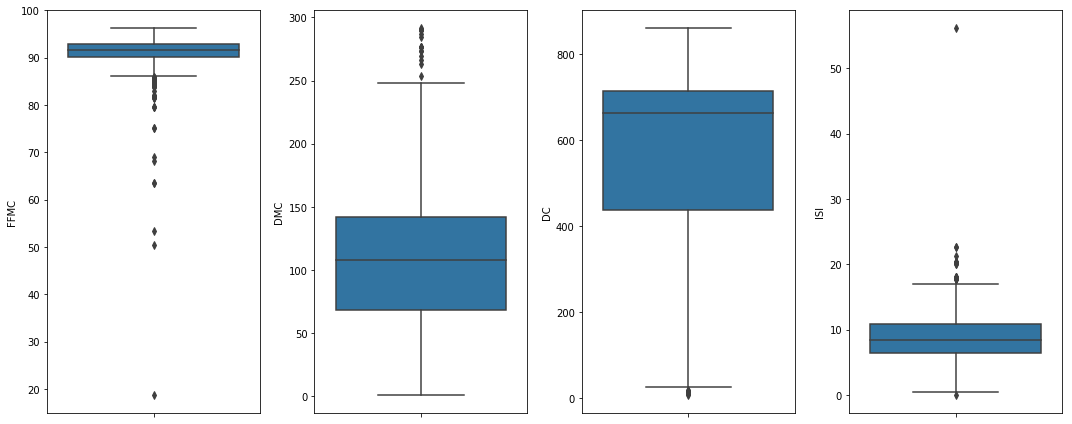

In [3]:
fig,ax = plt.subplots(1,4, figsize=(15, 6))
sns.boxplot(y="FFMC",data=df, ax=ax[0])
sns.boxplot(y="DMC",data=df, ax=ax[1])
sns.boxplot(y="DC",data=df,ax=ax[2])
sns.boxplot(y="ISI",data=df,ax=ax[3])

plt.tight_layout()

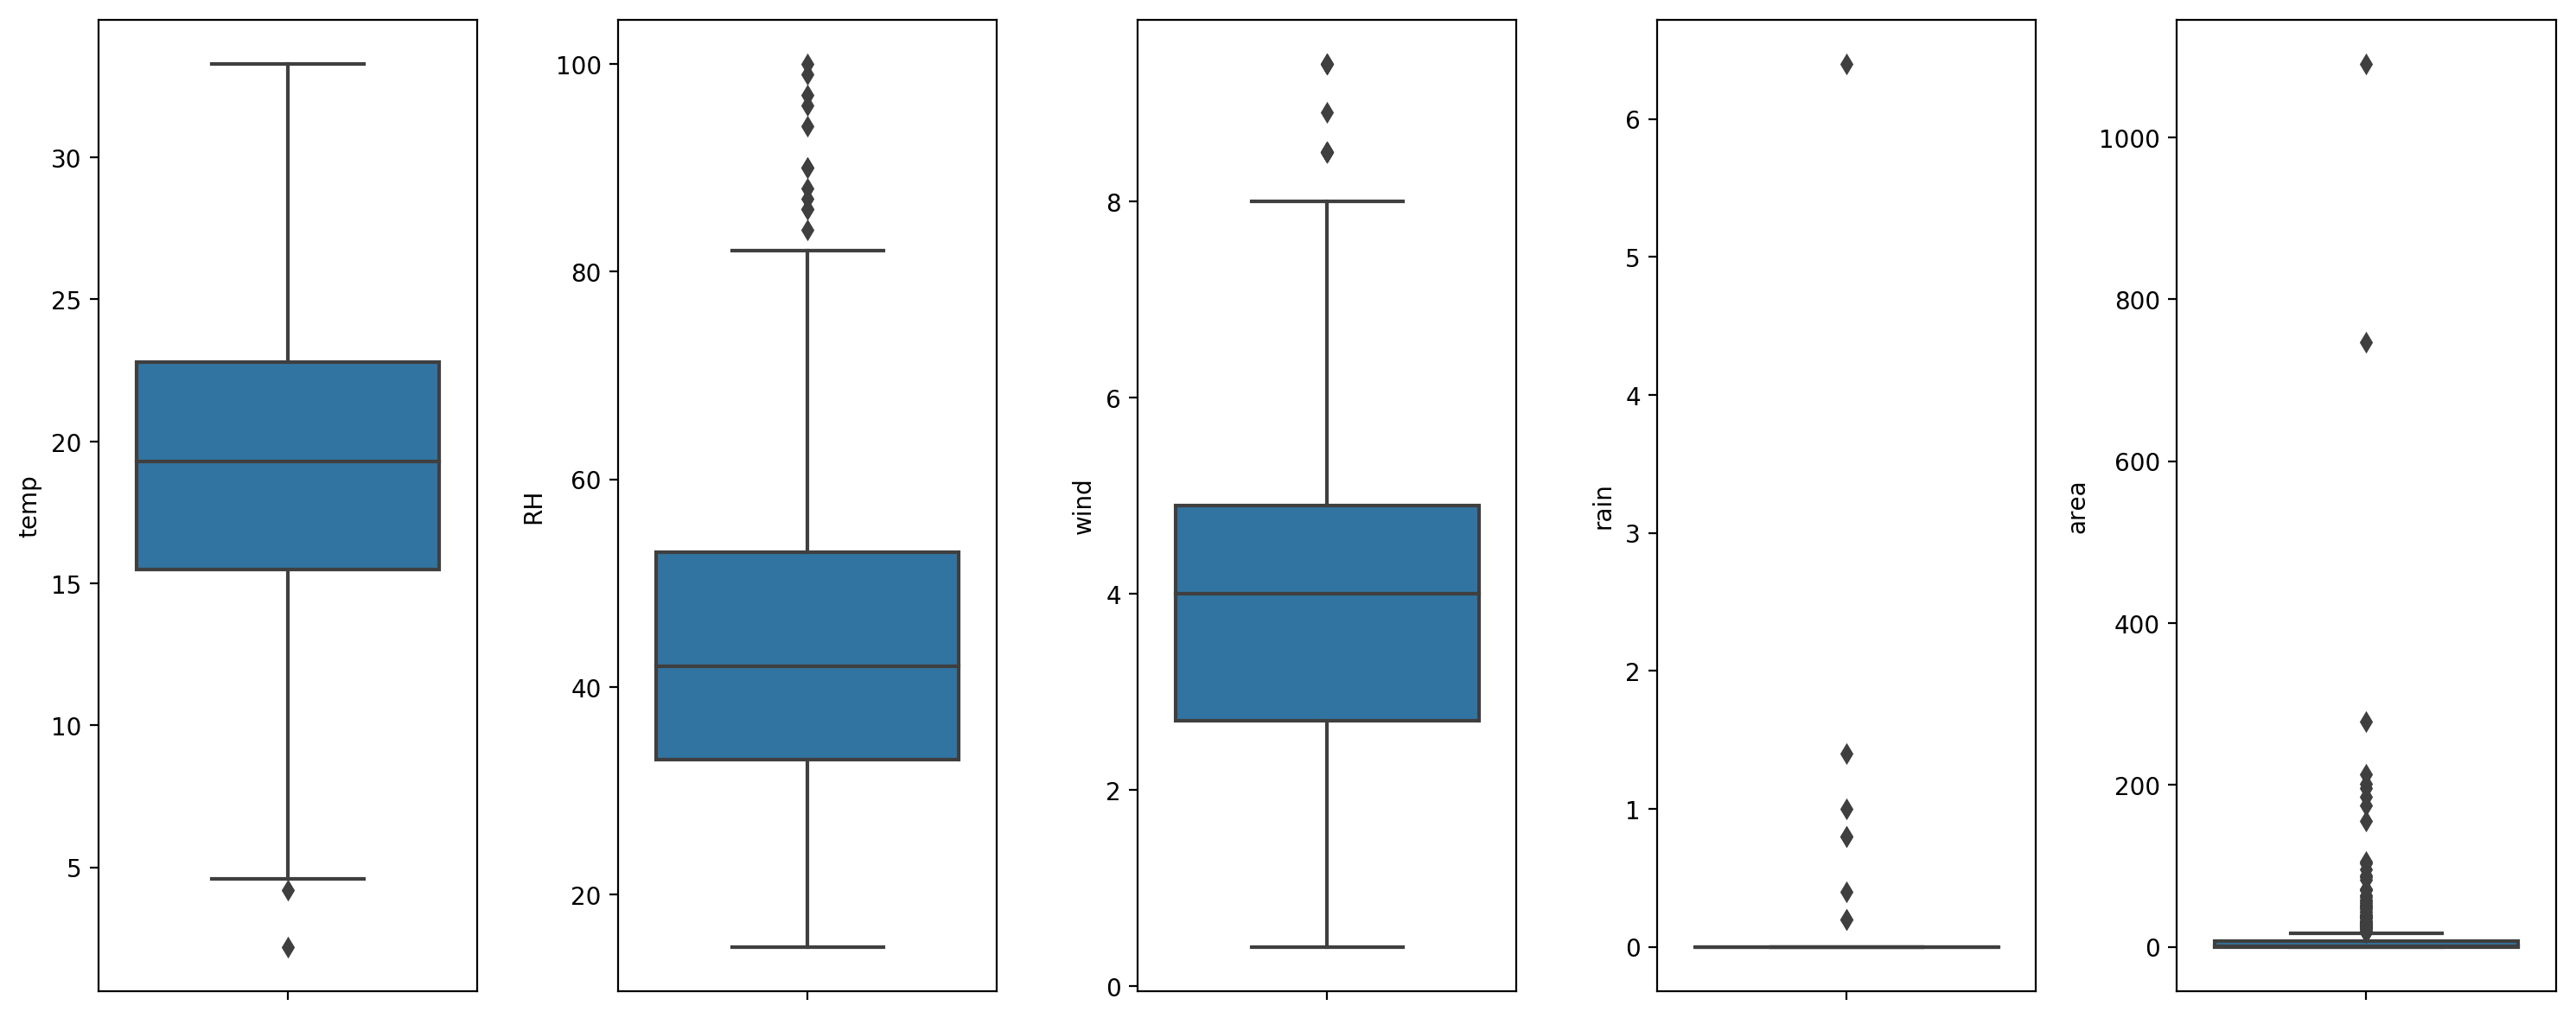

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6), dpi=200)
sns.boxplot(y="temp",data=df, ax=ax[0])
sns.boxplot(y="RH",data=df,ax=ax[1])
sns.boxplot(y="wind",data=df,ax=ax[2])
sns.boxplot(y="rain",data=df,ax=ax[3])
sns.boxplot(y="area",data=df,ax=ax[4])
plt.tight_layout()

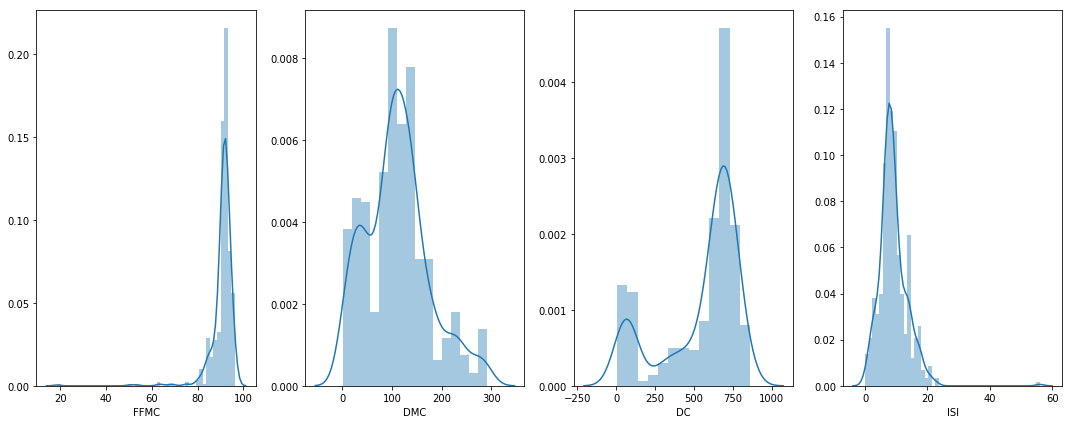

In [5]:
fig, ax = plt.subplots(1,4, figsize=(15, 6))
sns.distplot(df['FFMC'],ax=ax[0])
sns.distplot(df['DMC'],ax=ax[1])
sns.distplot(df['DC'],ax=ax[2])
sns.distplot(df['ISI'],ax=ax[3])
plt.tight_layout()

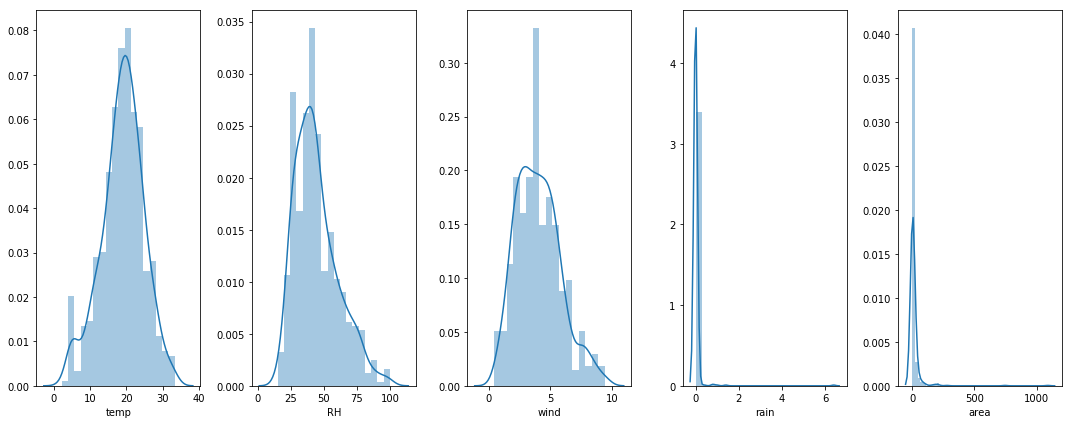

In [6]:
fig, ax = plt.subplots(1,5, figsize=(15, 6))
sns.distplot(df['temp'],ax=ax[0])
sns.distplot(df['RH'],ax=ax[1])
sns.distplot(df['wind'],ax=ax[2])
sns.distplot(df['rain'],ax=ax[3])
sns.distplot(df['area'],ax=ax[4])
plt.tight_layout()

### Outlier Removal

In [7]:
## FFMC OUTLIIER REMOVE

dfwo = df.copy()
dfwo.drop(['x_coord','y_coord','rain','month','day'], inplace=True, axis=1)


## FOR FFMC

q1, q3= np.percentile(dfwo['FFMC'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['FFMC'].loc[dfwo['FFMC'] < lower_bound]= lower_bound
# dfwo['FFMC'].loc[dfwo['FFMC'] > upper_bound] = upper_bound
outlier_FFMC=dfwo['FFMC'].loc[(dfwo['FFMC'] < lower_bound) | (dfwo['FFMC'] > upper_bound)]
outsum_FFMC=outlier_FFMC.count()
percent=(outsum_FFMC/dfwo["FFMC"].count())*100
print("Outlier FFMC %: ", percent)


## ISI

q1, q3= np.percentile(dfwo['ISI'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['ISI'].loc[dfwo['ISI'] < lower_bound] = lower_bound
# dfwo['ISI'].loc[dfwo['ISI'] > upper_bound] = upper_bound
outlier_ISI=dfwo['ISI'].loc[(dfwo['ISI'] < lower_bound) | (dfwo['ISI'] > upper_bound)]
outsum_ISI=outlier_ISI.count()
percent=(outsum_ISI/dfwo["ISI"].count())*100
print("Outlier ISI %: ", percent)

## DMC

q1, q3= np.percentile(dfwo['DMC'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['DMC'].loc[dfwo['DMC'] < lower_bound]= lower_bound
# dfwo['DMC'].loc[dfwo['DMC'] > upper_bound] = upper_bound
outlier_DMC=dfwo['DMC'].loc[(dfwo['DMC'] < lower_bound) | (dfwo['DMC'] > upper_bound)]
outsum_DMC=outlier_DMC.count()
percent=(outsum_DMC/dfwo["DMC"].count())*100
print("Outlier DMC %: ", percent)

# FOR DC

q1, q3= np.percentile(dfwo['DC'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['DC'].loc[dfwo['DC'] < lower_bound]= lower_bound
# dfwo['DC'].loc[dfwo['DC'] > upper_bound] = upper_bound
outlier_DC=dfwo['DC'].loc[(dfwo['DC'] < lower_bound) | (dfwo['DC'] > upper_bound)]
outsum_DC=outlier_DC.count()
percent=(outsum_DC/dfwo["DC"].count())*100
print("Outlier DC %: ", percent)

# FOR RH

q1, q3= np.percentile(dfwo['RH'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['RH'].loc[dfwo['RH'] < lower_bound]= lower_bound
# dfwo['RH'].loc[dfwo['RH'] > upper_bound] = upper_bound
outlier_RH=dfwo['RH'].loc[(dfwo['RH'] < lower_bound) | (dfwo['RH'] > upper_bound)]
outsum_RH=outlier_RH.count()
percent=(outsum_RH/dfwo["RH"].count())*100
print("Outlier RH %: ", percent)

# FOR wind

q1, q3= np.percentile(dfwo['wind'],[25,75])
ffmc_iqr = q3 - q1
lower_bound = q1 -(1.5 * ffmc_iqr) 
upper_bound = q3 +(1.5 * ffmc_iqr)
# dfwo['wind'].loc[dfwo['wind'] < lower_bound]= lower_bound
# dfwo['wind'].loc[dfwo['wind'] > upper_bound] = upper_bound
outlier_wind=dfwo['wind'].loc[(dfwo['wind'] < lower_bound) | (dfwo['wind'] > upper_bound)]
outsum_wind=outlier_wind.count()
percent=(outsum_wind/dfwo["wind"].count())*100
print("Outlier wind %: ", percent)

# FOR area

dfwo['area'] = np.log1p(dfwo['area'])
q1, q3= np.percentile(dfwo['area'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
# dfwo['area'].loc[(dfwo['area'] < lower_bound)]=lower_bound
# dfwo['area'].loc[(dfwo['area'] > upper_bound)]=upper_bound
outlier_area=dfwo['area'].loc[(dfwo['area'] < lower_bound) | (dfwo['area'] > upper_bound)]
outsum_area=outlier_area.count()
percent=(outsum_area/dfwo["area"].count())*100
print("Outlier Area %: ", percent)

## TEMP
q1, q3= np.percentile(dfwo['temp'],[25,75])
temp_iqr = q3 - q1
lower_bound = q1 -(1.5 * temp_iqr) 
upper_bound = q3 +(1.5 * temp_iqr)
outlier_temp=dfwo['temp'].loc[(dfwo['temp'] < lower_bound) | (dfwo['temp'] > upper_bound)]
outsum_temp=outlier_temp.count()
percent=(outsum_temp/dfwo["temp"].count())*100
print("Outlier Temp %: ", percent)



Outlier FFMC %:  10.251450676982591
Outlier ISI %:  4.448742746615087
Outlier DMC %:  3.2882011605415857
Outlier DC %:  1.5473887814313347
Outlier RH %:  2.321083172147002
Outlier wind %:  2.5145067698259185
Outlier Area %:  1.5473887814313347
Outlier Temp %:  0.3868471953578337


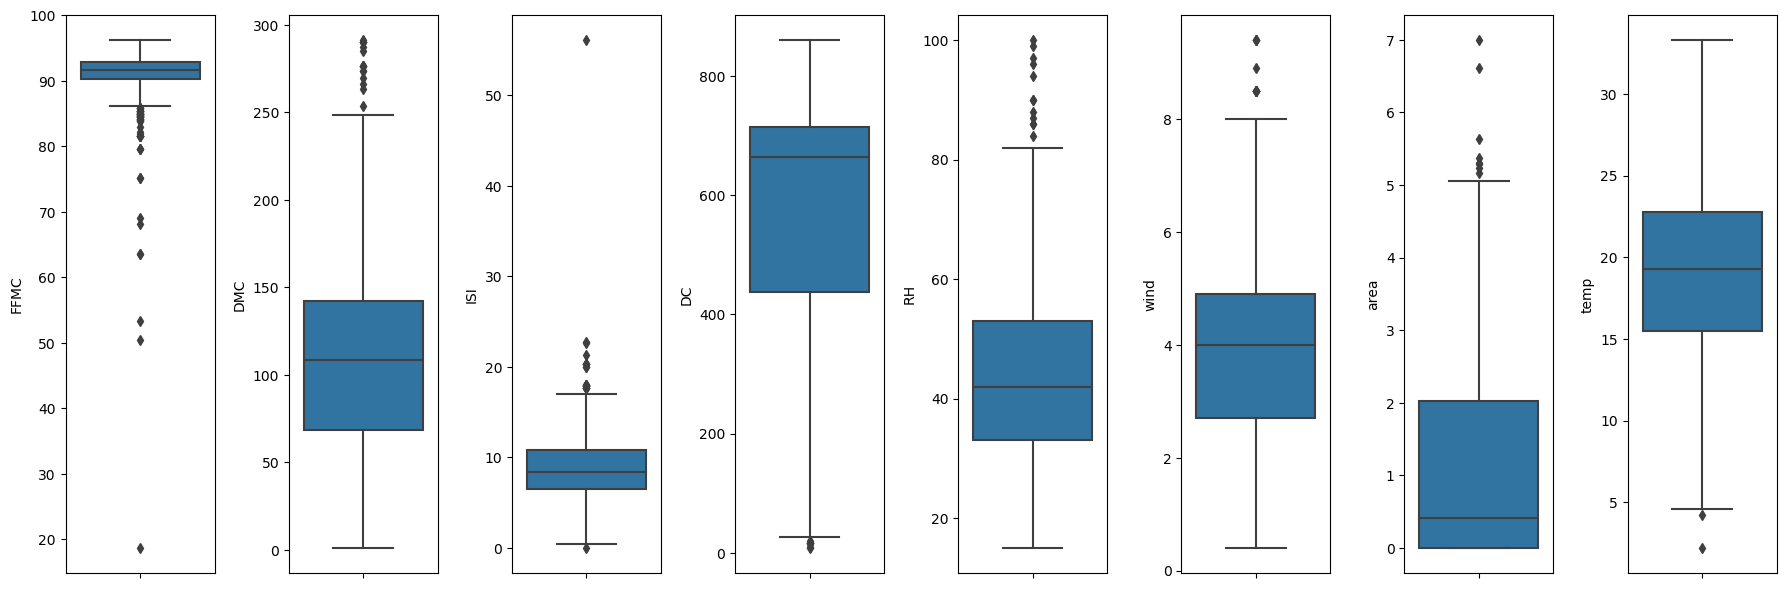

In [8]:
fig, ax = plt.subplots(1,8, figsize=(18, 6), dpi=100)

sns.boxplot(y="FFMC", data=dfwo, ax=ax[0])
sns.boxplot(y="DMC", data=dfwo, ax=ax[1])
sns.boxplot(y="ISI", data=dfwo, ax=ax[2])
sns.boxplot(y="DC", data=dfwo, ax=ax[3])
sns.boxplot(y="RH", data=dfwo, ax=ax[4])
sns.boxplot(y="wind", data=dfwo, ax=ax[5])
sns.boxplot(y="area", data=dfwo, ax=ax[6])
sns.boxplot(y="temp", data=dfwo, ax=ax[7])

plt.tight_layout()

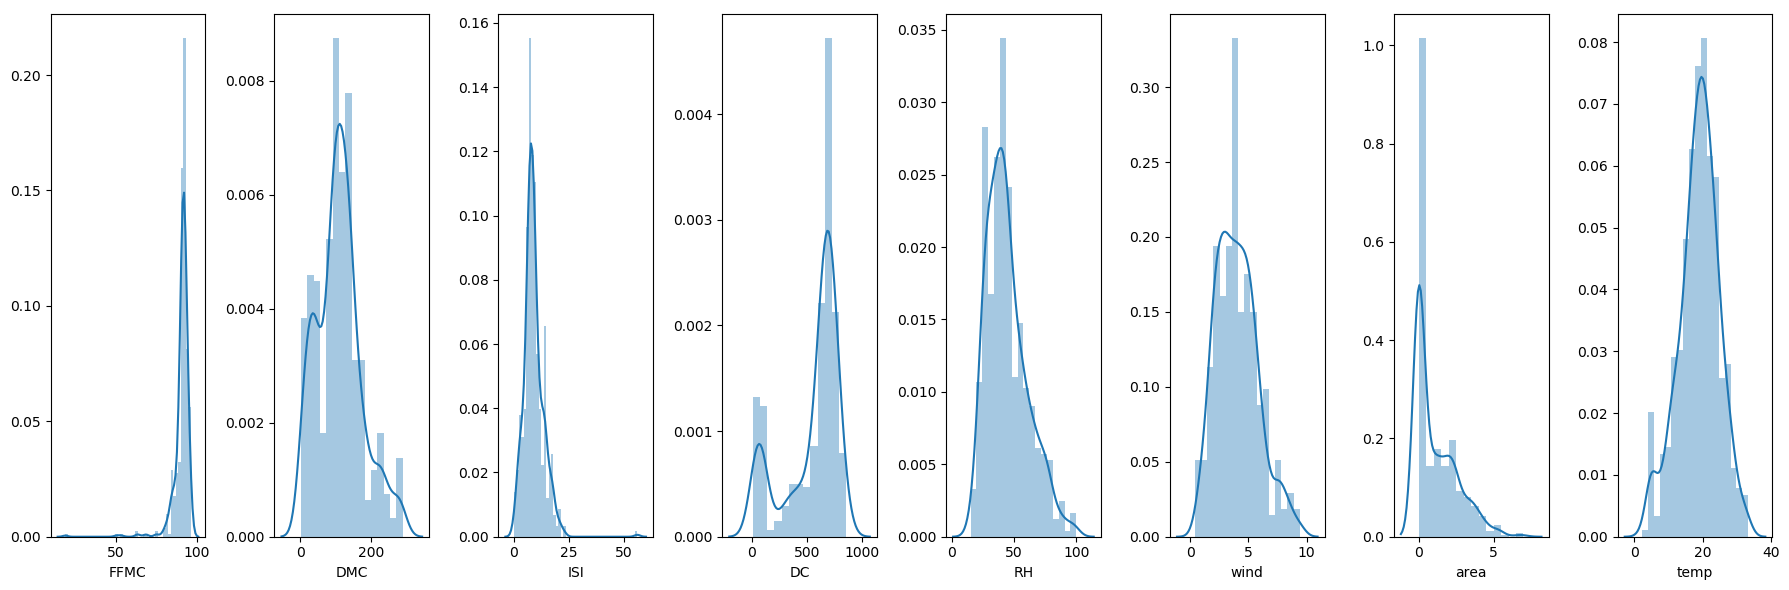

In [9]:
fig, ax = plt.subplots(1,8, figsize=(18, 6), dpi=100)

sns.distplot(dfwo['FFMC'], ax=ax[0])
sns.distplot(dfwo['DMC'], ax=ax[1])
sns.distplot(dfwo['ISI'], ax=ax[2])
sns.distplot(dfwo['DC'], ax=ax[3])
sns.distplot(dfwo['RH'], ax=ax[4])
sns.distplot(dfwo['wind'], ax=ax[5])
sns.distplot(dfwo['area'], ax=ax[6])
sns.distplot(dfwo["temp"], ax=ax[7])

plt.tight_layout()

In [10]:
#calculating the median value of area column
threshold = dfwo['area'].median()
dfwo.loc[df['area'] >= threshold, "forest_fire"] = 1
dfwo.loc[df['area'] < threshold, "forest_fire"] = 0
dfwo.drop('area', inplace=True, axis=1)
dfwo['forest_fire'].value_counts()
print(threshold)

0.41871033485818504


  Specs    Scores
0  FFMC  2.591106
1   DMC  1.765326
2    DC  3.993707
3   ISI  0.228672
4  temp  2.335908
5    RH  0.634481
6  wind  1.822332

Top 4 Features: 
   Specs    Scores
2    DC  3.993707
0  FFMC  2.591106
4  temp  2.335908
6  wind  1.822332


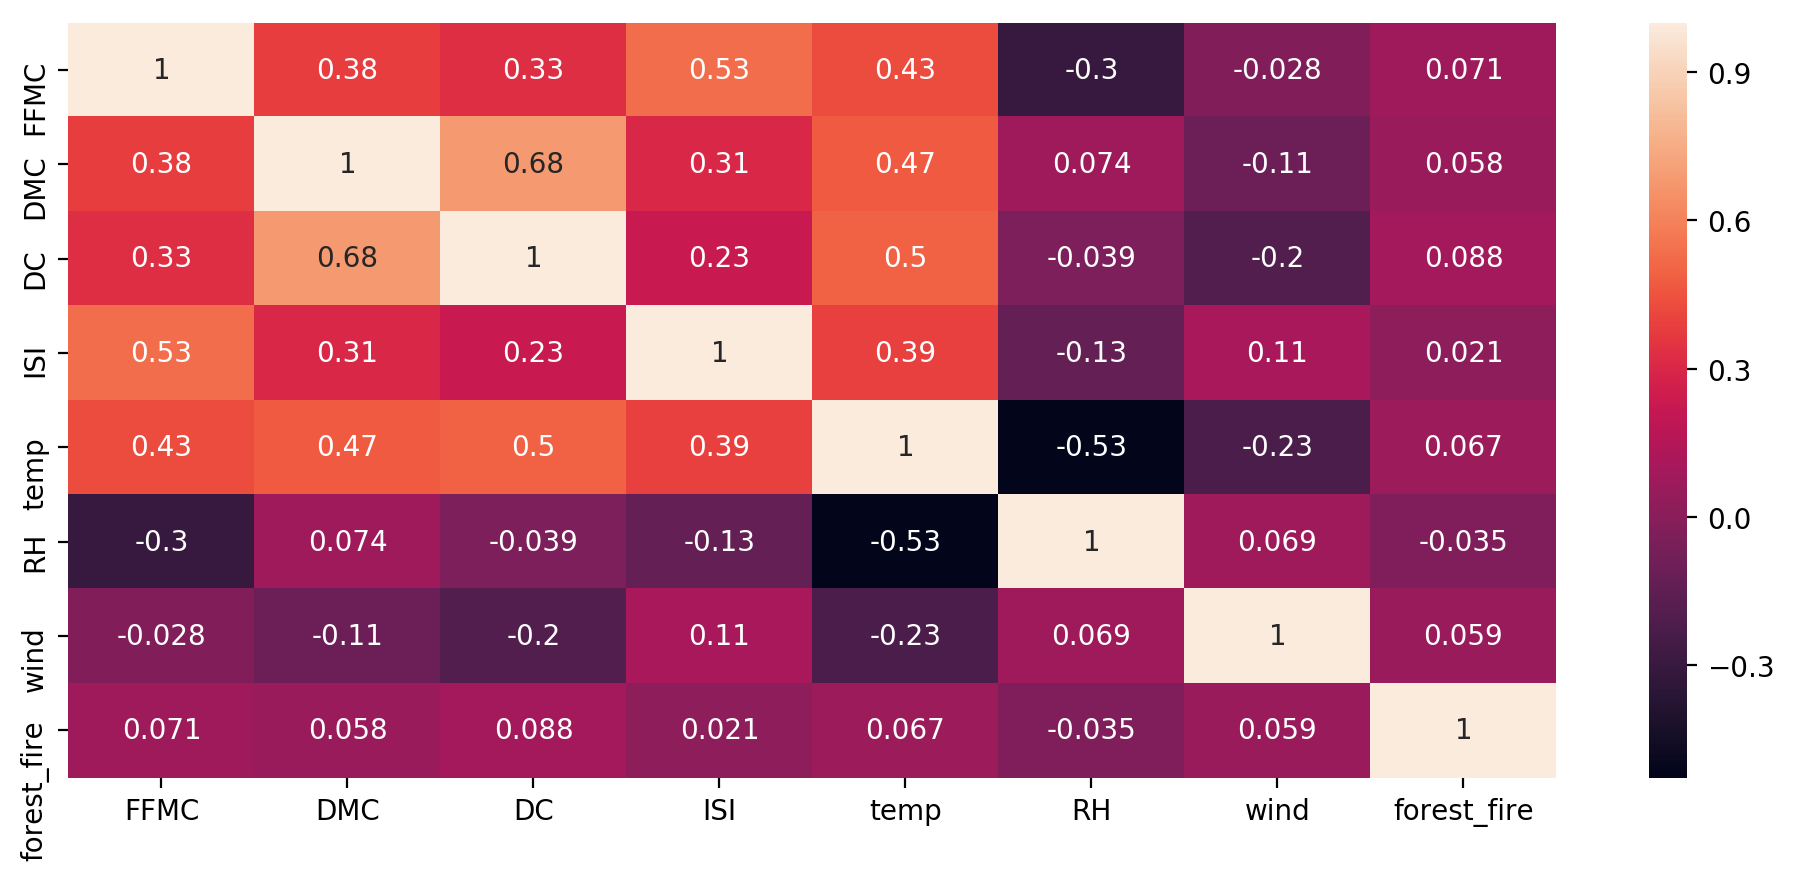

In [11]:
# Corelation
fig, ax = plt.subplots(1, 1, figsize=(12,5), dpi=200)
sns.heatmap(dfwo.corr(), ax=ax, annot=True, )

# Scaling DataFrame
sc=StandardScaler()
scaled_data = sc.fit_transform(dfwo.drop(['forest_fire'],axis=1).astype(float))
column_names = list(dfwo.columns)[:-1]


# Feature Selection

x= pd.DataFrame(scaled_data, columns=column_names)
y=dfwo['forest_fire']



selector = SelectKBest(score_func=f_classif, k=3)
selector.fit(x, y)
dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(x.columns)
featurescores = pd.concat([dfcolumns,dfscores],axis=1)
featurescores.columns = ['Specs','Scores']
print(featurescores)
print ("\nTop 4 Features: \n", featurescores.nlargest(4,'Scores'))


# Model Training

In [14]:
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=4)
kf = KFold(n_splits=math.floor(np.sqrt(len(x))), shuffle=True, random_state=4)
kf.get_n_splits(x)
i=0
y_pred_lgr, y_pred_knn, y_pred_dt, y_pred_gnb = [], [], [], []
score_lgr, score_knn, score_dt, score_gnb, test_in = [], [], [], [], []

for train_index, test_index in kf.split(x):
   
    test_in.append(test_index)
    
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Logistic Regression Model
    
    logisticRegrModel = LogisticRegression(solver="liblinear")
    logisticRegrModel.fit(x_train, y_train)
    y_pred_lgr.append(logisticRegrModel.predict(x_test))
    score_lgr.append(accuracy_score(y_test,y_pred_lgr[i]))

    # KNN

    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(x_train,y_train)
    y_pred_knn.append(knn_model.predict(x_test))
    score_knn.append(accuracy_score(y_test,y_pred_knn[i]))


    # Decision Tree

    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(x_train,y_train)
    y_pred_dt.append(dtree_model.predict(x_test))
    score_dt.append(accuracy_score(y_test, y_pred_dt[i]))
    
    # Gausian Naive Bayes
    gnb_model=GaussianNB()
    gnb_model.fit(x_train, y_train)
    y_pred_gnb.append(gnb_model.predict(x_test))
    score_gnb.append(accuracy_score(y_test, y_pred_gnb[i]))
    

    
    # index counter
    i=i+1

    
# Print Scores
print("\nMax Accuracy Score of Logistic Regression model is :", max(score_lgr) )
print("\nMax Accuracy Score of KNN model is :",  max(score_knn) )
print("\nMax Accuracy Score of decision tree model is :", max(score_dt))
print("\nMax Accuracy Score of Gausian Naive Bayes model is :", max(score_gnb))


Max Accuracy Score of Logistic Regression model is : 0.6521739130434783

Max Accuracy Score of KNN model is : 0.8333333333333334

Max Accuracy Score of decision tree model is : 0.75

Max Accuracy Score of Gausian Naive Bayes model is : 0.7916666666666666


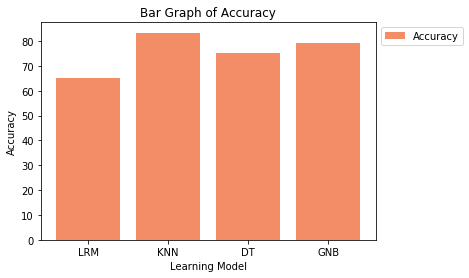

In [15]:
#Creting bar plot between the learning model and their accuracy score
#In x axis storing the name of the Learning model and in Y axis storing the name of accuracy score
learning_model = ["LRM" , "KNN" , "DT" , "GNB"]
accuracy = [ max(score_lgr) *100 ,  max(score_knn)*100  , max(score_dt) *100 , max(score_gnb)*100 ]
x_pos = np.arange(len(learning_model))
#Defination of each axis
plt.xticks(x_pos,learning_model)
plt.ylabel("Accuracy")
plt.xlabel("Learning Model")
plt.title("Bar Graph of Accuracy")

plt.bar(x_pos,accuracy,label="Accuracy", color="#F38D68")

plt.legend(bbox_to_anchor=(1, 1))

plt.show()

In [16]:
#finding the best y_pred
y_pred_lgr=y_pred_lgr[score_lgr.index(max(score_lgr))]
y_pred_knn=y_pred_knn[score_knn.index(max(score_knn))]
y_pred_dt=y_pred_dt[score_dt.index(max(score_dt))]
y_pred_gnb=y_pred_gnb[score_gnb.index(max(score_gnb))]


#finding the y_test respect to best score
y_test_lgr=y.iloc[test_in[score_lgr.index(max(score_lgr))]]
y_test_knn=y.iloc[test_in[score_knn.index(max(score_knn))]]
y_test_dt=y.iloc[test_in[score_dt.index(max(score_dt))]]
y_test_gnb=y.iloc[test_in[score_gnb.index(max(score_gnb))]]

## Evaluation

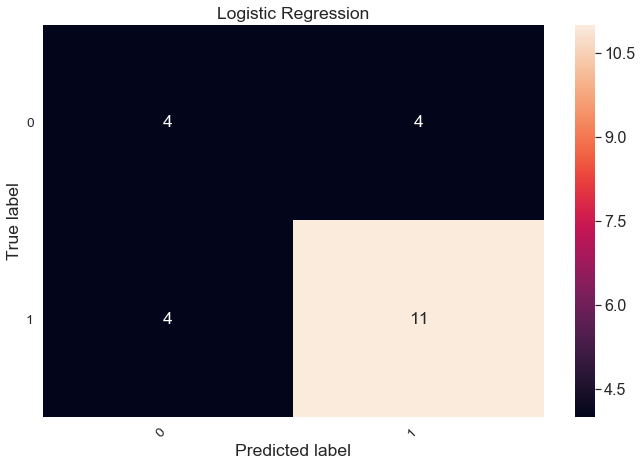


Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         8
         1.0       0.73      0.73      0.73        15

   micro avg       0.65      0.65      0.65        23
   macro avg       0.62      0.62      0.62        23
weighted avg       0.65      0.65      0.65        23



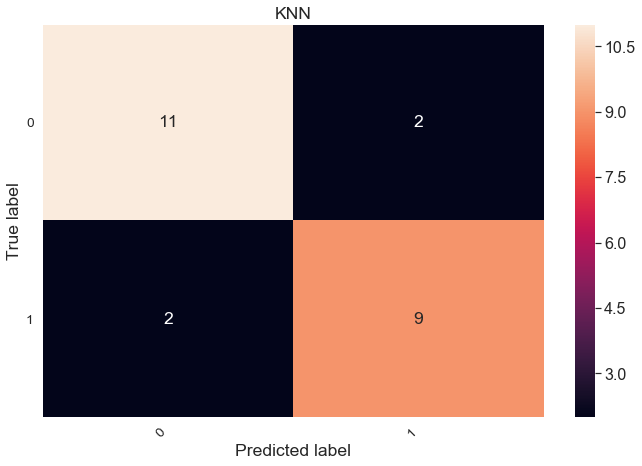


Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        13
         1.0       0.82      0.82      0.82        11

   micro avg       0.83      0.83      0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24



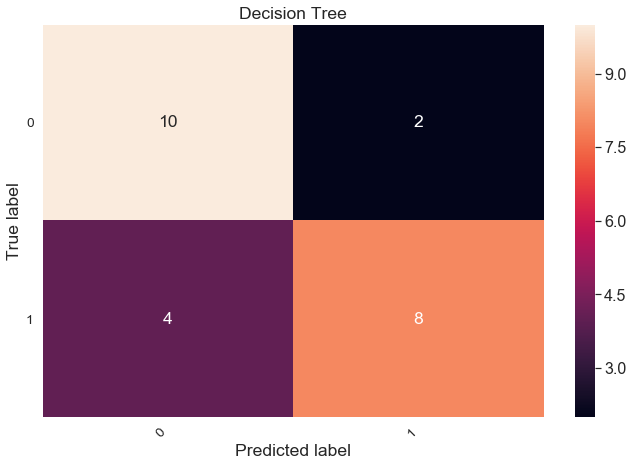


Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77        12
         1.0       0.80      0.67      0.73        12

   micro avg       0.75      0.75      0.75        24
   macro avg       0.76      0.75      0.75        24
weighted avg       0.76      0.75      0.75        24



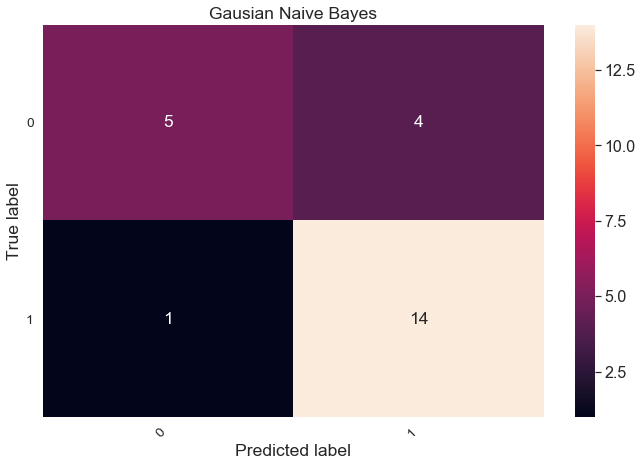


Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.56      0.67         9
         1.0       0.78      0.93      0.85        15

   micro avg       0.79      0.79      0.79        24
   macro avg       0.81      0.74      0.76        24
weighted avg       0.80      0.79      0.78        24



In [17]:
# Confusion Matrix and report

def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, title="Confusion Matrix"):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize, dpi=70)
    try:
        sns.set(font_scale=1.5)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

conf_mat_lgr=confusion_matrix(y_test_lgr, y_pred_lgr)
# print("Confusion matrix for Logistic Regression: \n", conf_mat_lgr)
plot_confusion_matrix(conf_mat_lgr, class_names=['0','1'],title="Logistic Regression")
print("\nReport: \n", classification_report(y_test_lgr, y_pred_lgr))

conf_mat_knn=confusion_matrix(y_test_knn, y_pred_knn)
# print("Confusion matrix for KNN: \n", conf_mat_knn)
plot_confusion_matrix(conf_mat_knn, class_names=['0','1'], title="KNN")

print("\nReport: \n", classification_report(y_test_knn, y_pred_knn))

conf_mat_dt=confusion_matrix(y_test_dt, y_pred_dt)
# print("Confusion matrix for Decision Tree: \n", conf_mat_dt)
plot_confusion_matrix(conf_mat_dt, class_names=['0','1'], title="Decision Tree")
print("\nReport: \n", classification_report(y_test_dt, y_pred_dt))

conf_mat_gnb=confusion_matrix(y_test_gnb, y_pred_gnb)
# print("Confusion matrix for Decision Tree: \n", conf_mat_dt)
plot_confusion_matrix(conf_mat_gnb, class_names=['0','1'], title="Gausian Naive Bayes")
print("\nReport: \n", classification_report(y_test_gnb, y_pred_gnb))



## Strong Learner

In [18]:
# Ensemble Learning
kf=KFold(n_splits=math.floor(np.sqrt(len(x))), shuffle=True, random_state=4)

# Voting Learner
ens_model = VotingClassifier(estimators=[('lgr', logisticRegrModel), ('knn', knn_model), ('dt', dtree_model), ('gnb', gnb_model)])
result_vote=model_selection.cross_val_score(ens_model, x_train, y_train, cv=kf)
print(result_vote.mean()*100)

# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
result_rf=model_selection.cross_val_score(rf_model, x_train, y_train, cv=kf)
print(result_rf.mean()*100)

# Bagging Classifier
bag_model = BaggingClassifier()
result_bag=model_selection.cross_val_score(bag_model, x_train, y_train, cv=kf)
print(result_bag.mean()*100)

55.27308659719728
56.66546891843335
54.68020122170319
